<a href="https://colab.research.google.com/github/ThePina/Machine-learning-final-project/blob/main/ProyectoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import requests
import io
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.model_selection import train_test_split
import csv
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

#obtencion de los datos

In [2]:
#Creación del DataFrame con los datos del archivo csv descargado del url
url = 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=xcl&macro=./RVII/709/Cal/PM25//PM25.horario.horario.ic&from=120707&to=211130&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='

data = requests.get(url)
lines = data.text.splitlines()
reader = csv.reader(lines,delimiter=';')
df = pd.DataFrame(reader)
df.drop([5], axis=1,inplace=True)
df.drop([0], axis=0,inplace=True)
df.columns = ["FECHA (YYMMDD)",	"HORA (HHMM)"	,"Registros validados"	,"Registros preliminares"	,"Registros no validados"]
df.reset_index()
df

,FECHA (YYMMDD),HORA (HHMM),Registros validados,Registros preliminares,Registros no validados
1,120707,0100,,,
2,120707,0200,,,
3,120707,0300,,,
4,120707,0400,,,
5,120707,0500,,,
...,...,...,...,...,...
82411,211130,1900,,3,
82412,211130,2000,,7,
82413,211130,2100,,7,
82414,211130,2200,,11,


#Análisis de datos
Antes de hacer algo, se tuvo que modificar los registros, ya que estos venían con ',' y para pasarlos a flotantes era necesario '.'.
también por fines prácticos los datos que no se encontraban registrados se transformaron en 0. Ya que facilitara la unión de los registros de concentración de contaminación del aire.


In [3]:
df=df.replace('',0.0)
df['Registros validados']=df['Registros validados'].str.replace(',','.').astype(float)
df['Registros preliminares']=df['Registros preliminares'].str.replace(',','.').astype(float)
df['Registros no validados']=df['Registros no validados'].str.replace(',','.').astype(float)
df=df.replace(np.nan,0.0)
df

,FECHA (YYMMDD),HORA (HHMM),Registros validados,Registros preliminares,Registros no validados
1,120707,0100,0.0,0.0,0.0
2,120707,0200,0.0,0.0,0.0
3,120707,0300,0.0,0.0,0.0
4,120707,0400,0.0,0.0,0.0
5,120707,0500,0.0,0.0,0.0
...,...,...,...,...,...
82411,211130,1900,0.0,3.0,0.0
82412,211130,2000,0.0,7.0,0.0
82413,211130,2100,0.0,7.0,0.0
82414,211130,2200,0.0,11.0,0.0


###Unión de la fecha
Para la unión de las fechas se tomó la "FECHA (YYMMDD)"	"HORA (HHMM)"	y se combinaron una sola celda para poder tener el formato "YYMMDDHHMM" y posteriormente pasarlo a el formato Date para poder trabajarlos de una manera eficiente durante el desarrollo.
De esta manera es posible asociar una fecha con una hora en una sola celda a los datos registrados de concentración de contaminación del aire.


In [4]:

df['Fecha'] =df['FECHA (YYMMDD)']+df['HORA (HHMM)']
df['Fecha'] = pd.to_datetime(df['Fecha'], format="%y%m%d%H%M")
df

,FECHA (YYMMDD),HORA (HHMM),Registros validados,Registros preliminares,Registros no validados,Fecha
1,120707,0100,0.0,0.0,0.0,2012-07-07 01:00:00
2,120707,0200,0.0,0.0,0.0,2012-07-07 02:00:00
3,120707,0300,0.0,0.0,0.0,2012-07-07 03:00:00
4,120707,0400,0.0,0.0,0.0,2012-07-07 04:00:00
5,120707,0500,0.0,0.0,0.0,2012-07-07 05:00:00
...,...,...,...,...,...,...
82411,211130,1900,0.0,3.0,0.0,2021-11-30 19:00:00
82412,211130,2000,0.0,7.0,0.0,2021-11-30 20:00:00
82413,211130,2100,0.0,7.0,0.0,2021-11-30 21:00:00
82414,211130,2200,0.0,11.0,0.0,2021-11-30 22:00:00


#Gráfico de tiempo con los datos separados
A continuación, se muestra el grafico con la línea de tiempo con los datos de concentración de contaminación del aire separados por separado, es decir Registros validados, Registros preliminares y Registros no validados.


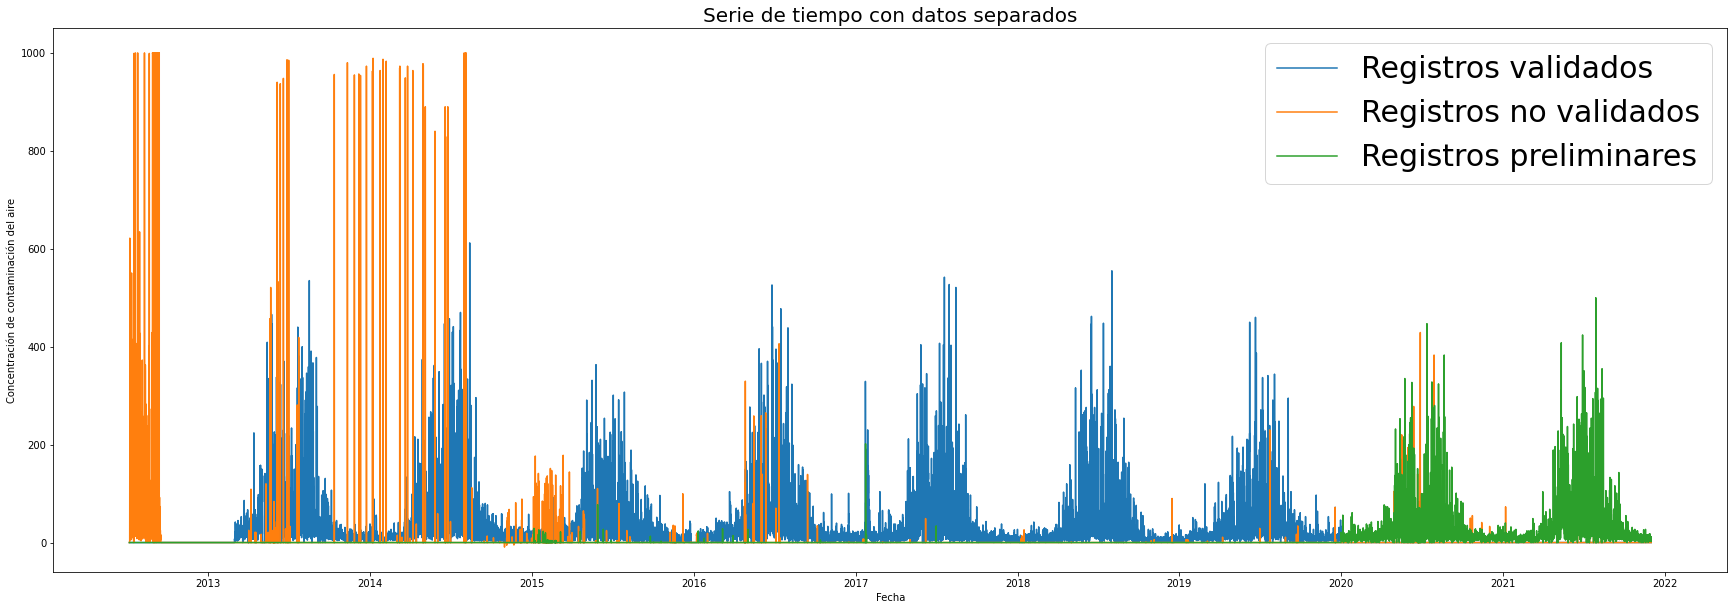

In [5]:
x = np.array(df['Fecha'])
y1 = np.array(df['Registros validados'])
y2 = np.array(df['Registros preliminares'])
y3 = np.array(df['Registros no validados'])
plt.figure(figsize=(30, 10))


plt.plot(x,y1,label="Registros validados")
plt.plot(x,y3,label="Registros no validados")
plt.plot(x,y2,label="Registros preliminares")
plt.legend(prop={'size': 30},)
plt.title("Serie de tiempo con datos separados", fontsize=20)
plt.xlabel('Fecha') 
plt.ylabel('Concentración de contaminación del aire')
plt.show()

Como se puede observar los registros no validados en su gran mayoría se escapan de un rango razonable de los datos (datos atípicos), por lo que se optó por eliminar dichos datos para obtener los datos en un rango más acotado, lo que ayudara a que el entrenamiento del modelo sea más eficaz.

#Grafico sin Registro no validados

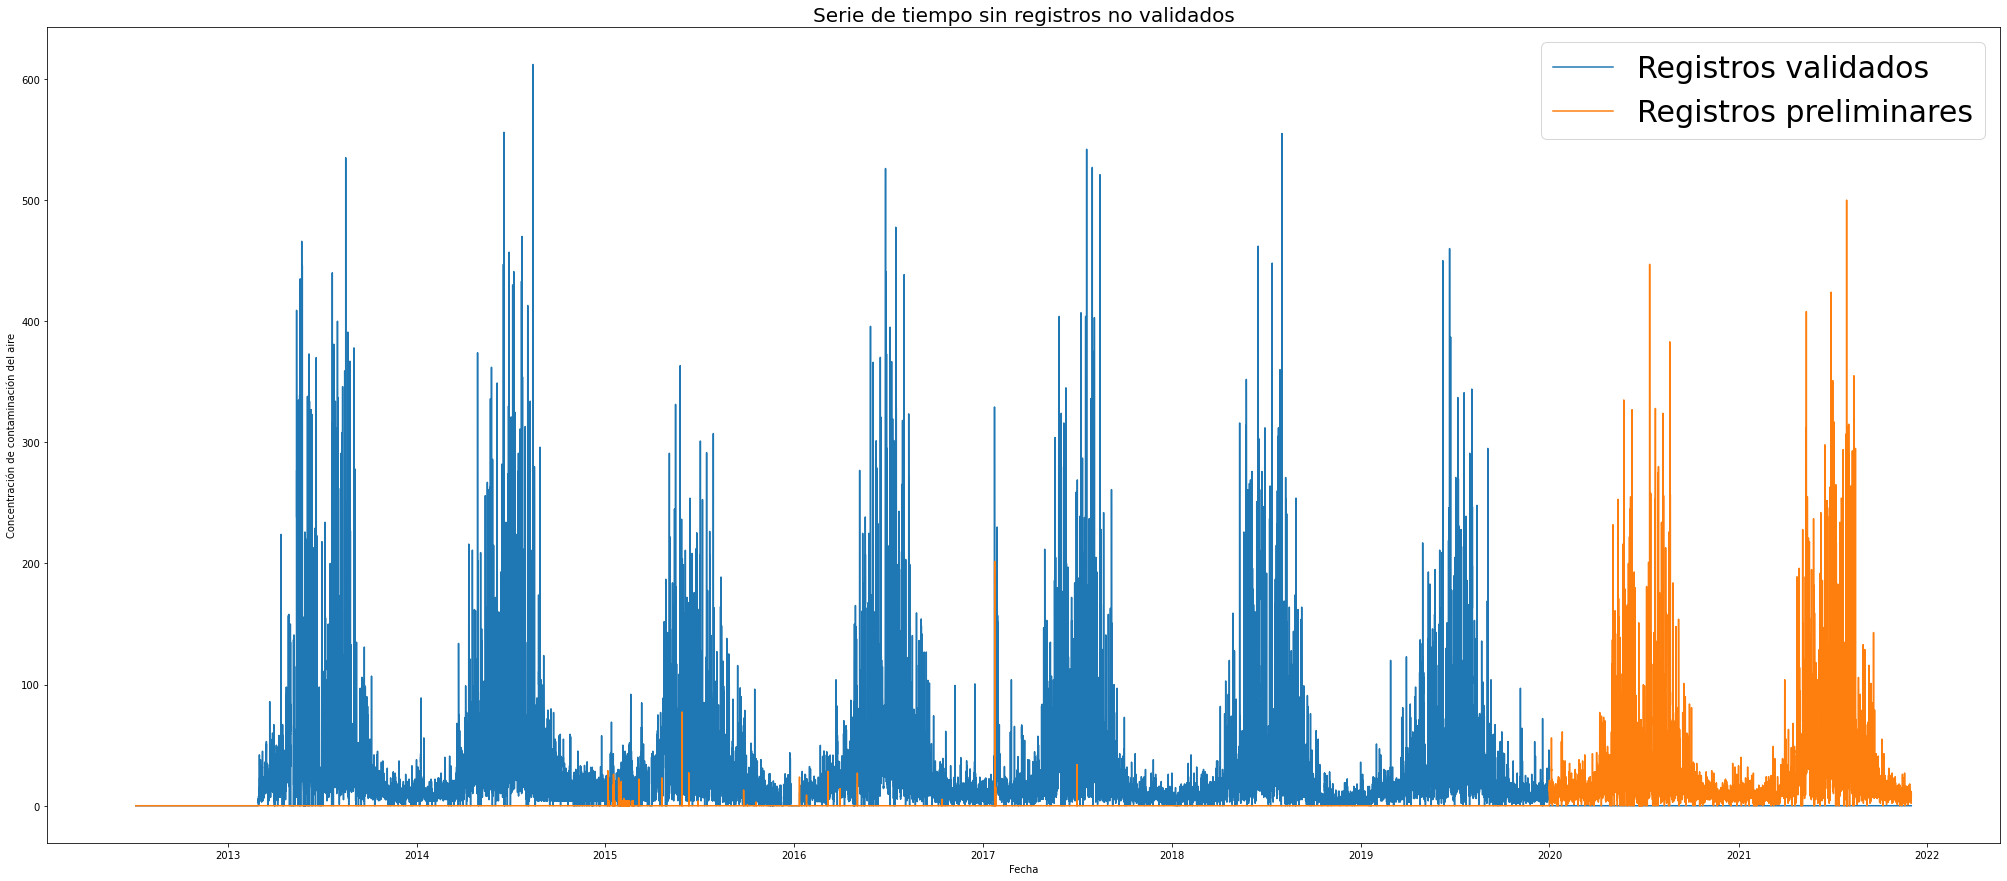

In [6]:
x = np.array(df['Fecha'])
y1 = np.array(df['Registros validados'])
y2 = np.array(df['Registros preliminares'])

plt.figure(figsize=(35, 15))

plt.xlabel('Fecha') 
plt.ylabel('Concentración de contaminación del aire')
plt.plot(x,y1,label="Registros validados")
plt.plot(x,y2,label="Registros preliminares")
plt.legend(prop={'size': 30})
plt.title("Serie de tiempo sin registros no validados", fontsize=20)
plt.show()

Como se puede observar los datos ya se encuentran en rango más pequeño lo que ayudara al modelo en el entrenamiento.
Gracias a la eliminación de esos datos, podemos ver más fácilmente un patrón en la línea temporal.


#Union de los datos
Como anteriormente se dijo se eliminarán los registros no validados, por lo que los registros generales de concentración de contaminación del aire que se usaran corresponden a los preliminares o los validados, dependiendo de cual esté disponible en cada fecha. Además, se eliminarán las fechas que no tengan ningún registro, ya que esto podría alterar la fiabilidad del modelo que se utilizara.


In [7]:
df2=pd.DataFrame()
df2['Fecha']= df['Fecha']
df2['valor'] = df['Registros validados']+df['Registros preliminares']
#df2['valor Promedio'] = df2.valor.rolling(24).mean() 
df2 = df2[df2.valor != 0.0]
df2 = df2.reset_index()
df2

,index,Fecha,valor
0,5688,2013-03-01 00:00:00,6.0
1,5689,2013-03-01 01:00:00,3.0
2,5690,2013-03-01 02:00:00,4.0
3,5691,2013-03-01 03:00:00,4.0
4,5692,2013-03-01 04:00:00,2.0
...,...,...,...
74222,82411,2021-11-30 19:00:00,3.0
74223,82412,2021-11-30 20:00:00,7.0
74224,82413,2021-11-30 21:00:00,7.0
74225,82414,2021-11-30 22:00:00,11.0


#Promedio Diario
Se calculará el promedio diario de los registros, para poder tener un modelo basado en días, lo que ayudará a ajustar el modelo puesto que los datos tendrá una menor dispersión.


In [8]:
dfMean=pd.DataFrame()
dfMean['fecha']=	df['FECHA (YYMMDD)']

dfMean['valor'] = df['Registros validados']+df['Registros preliminares']
dfMean = dfMean[dfMean.valor != 0.0]
grouped_df = dfMean.groupby("fecha")
mean_df = grouped_df.mean()
mean_df = mean_df.reset_index()
dfMean=(mean_df)

dfMean['fecha'] = pd.to_datetime(dfMean['fecha'], format="%y%m%d")



#Gráfico con los datos unidos
Gráfico en el tiempo con los registros agrupados por horas y por promedio diario.


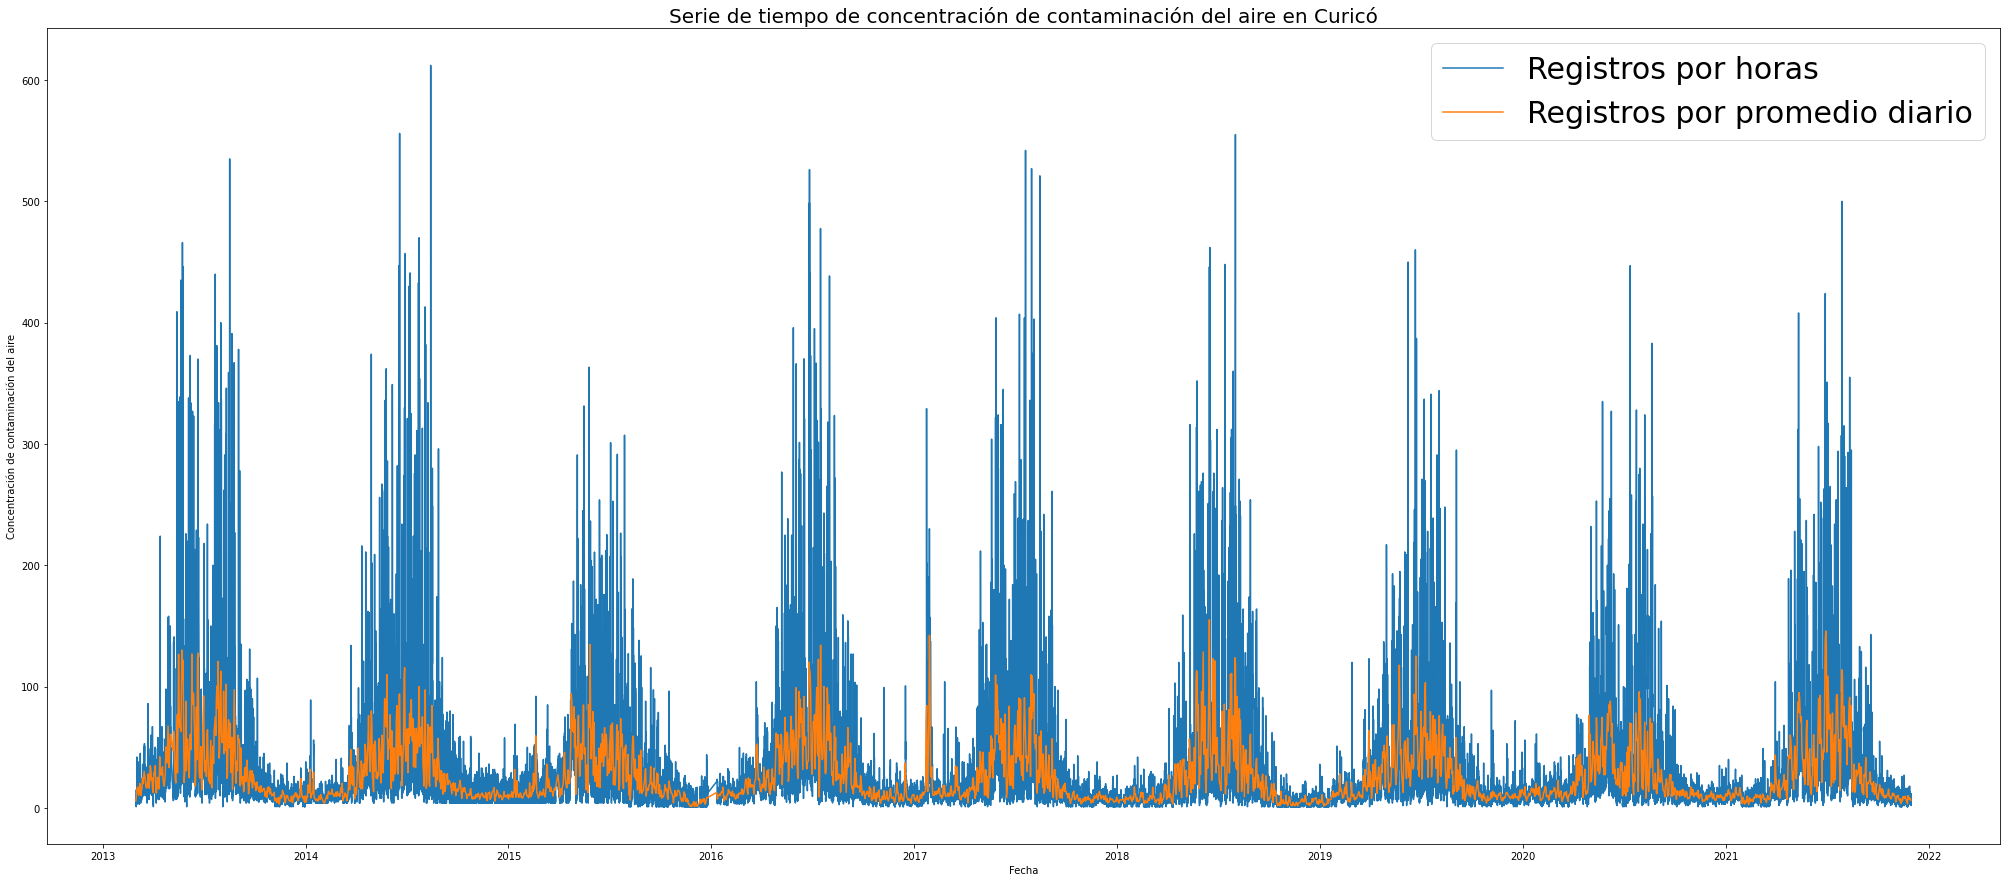

In [9]:
x1 = np.array(df2['Fecha'])
x2 = np.array(dfMean['fecha'])
y1 = np.array(df2['valor'])
y2 = np.array(dfMean['valor'])

plt.figure(figsize=(35, 15))
plt.plot(x1,y1,label="Registros por horas")
plt.plot(x2,y2,label="Registros por promedio diario")
plt.legend(prop={'size': 30})
plt.title("Serie de tiempo de concentración de contaminación del aire en Curicó", fontsize=20)
plt.xlabel('Fecha') 
plt.ylabel('Concentración de contaminación del aire')
plt.show()

Como se puede observar en el grafico anterior los registros por promedio diario muestran una dispersión menor a los registros por hora, lo cual debería arrogar mejores resultados en el modelo, por lo que realizaran pruebas con ambos tipos de agrupaciones de datos en el modelo para compararlas.

#Model Prophet datos por horas

In [26]:
#datos de entrenamiento hasta el 2020-01-01 y el resto de pruebas, se uso esta 
#fecha ya que aproximadamente un 20% de los datos totales, lo que deja un 80% 



#la separacion de los datos se realiza en base a una fecha limite que en este 
#caso es el comiezo de 2020, no con porcentajes, ya que tenemos un mayor control.
train_range = df2[df2.Fecha < '2020-01-01'].index
test_range = df2[(df2.Fecha >= '2020-01-01')].index
train_range

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            57813, 57814, 57815, 57816, 57817, 57818, 57819, 57820, 57821,
            57822],
           dtype='int64', length=57823)

##Grafico con separación de datos por pruebas y entrenamiento.

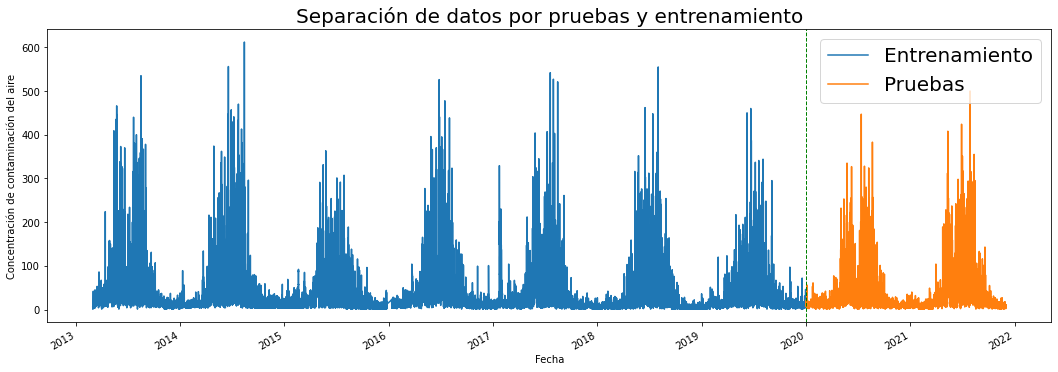

In [11]:
fig, ax = plt.subplots(figsize=(18,6))
df2.loc[train_range].plot(x="Fecha", y="valor", ax=ax, label="Entrenamiento")
df2.loc[test_range].plot(x="Fecha", y="valor", ax=ax, label="Pruebas")

plt.axvline(pd.to_datetime(str(df2.loc[test_range].Fecha.values[0])), c='green', ls='--', lw=1)
plt.legend(prop={'size': 20})
plt.title("Separación de datos por pruebas y entrenamiento", fontsize=20)
plt.xlabel('Fecha') 
plt.ylabel('Concentración de contaminación del aire')

plt.show()

#Entrenamiento

In [12]:
df_prophet_train = df2.loc[train_range][["Fecha", "valor"]]
df_prophet_train.columns = ["ds", "y"]
model = Prophet()
model.fit(df_prophet_train);

#Pruebas

In [13]:
df_prophet_test = df2.loc[test_range][["Fecha", "valor"]]
df_prophet_test.columns = ["ds", "y"]

forecast = model.predict(df_prophet_test[['ds']])

forecast_ci = forecast[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')

yhat_test = forecast.yhat.values
y_test = df2.loc[test_range].valor.values

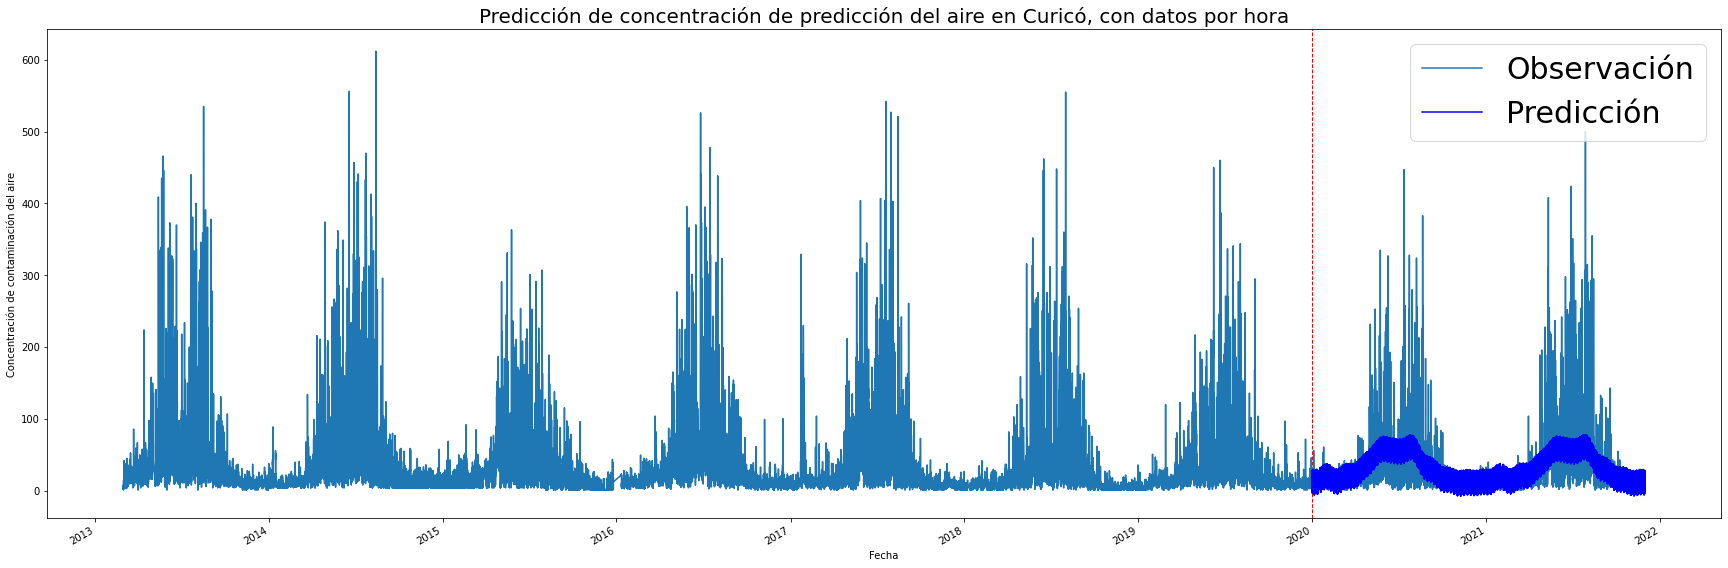

In [14]:
fig, ax = plt.subplots(figsize=(30,10))


plt.axvline(pd.to_datetime(str(df2.loc[test_range].Fecha.values[0])), c='red', ls='--', lw=1)
df2.plot(x="Fecha", y="valor", ax=ax, label="Observación")

ax.plot(pd.to_datetime(df2.loc[test_range].Fecha.values), yhat_test,
        color="blue", label="Predicción")

plt.legend(loc='best')
plt.title("Predicción de concentración de predicción del aire en Curicó, con datos por hora", fontsize=20)
plt.legend(prop={'size': 30},)
plt.xlabel('Fecha') 
plt.ylabel('Concentración de contaminación del aire')
plt.show()

Como se puede ver los resultados del modelo, este se parecen levemente a los a los registros reales, esto se puede deber a que la dispersión de los datos es muy elevada.

###Gráficos con información de concentración de contaminación en el aire de Curicó 

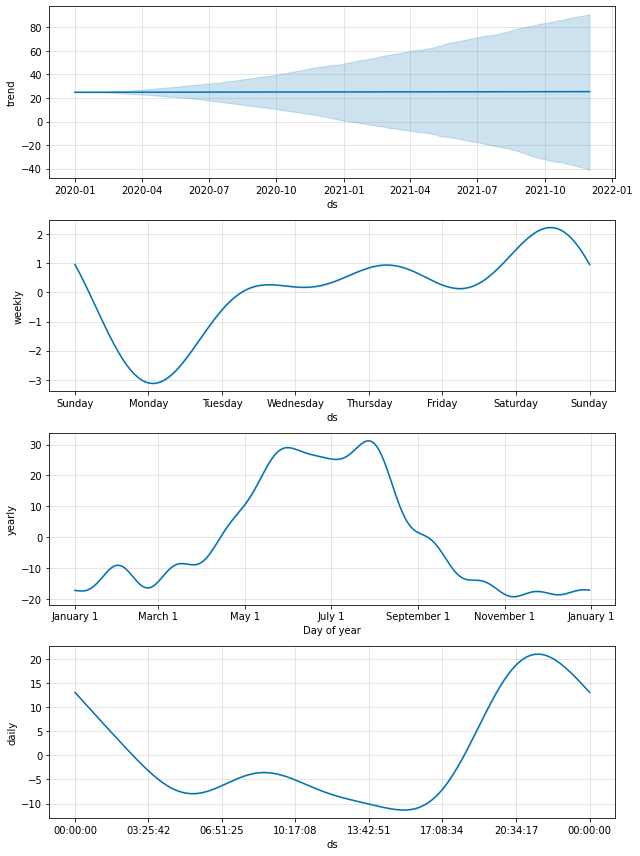

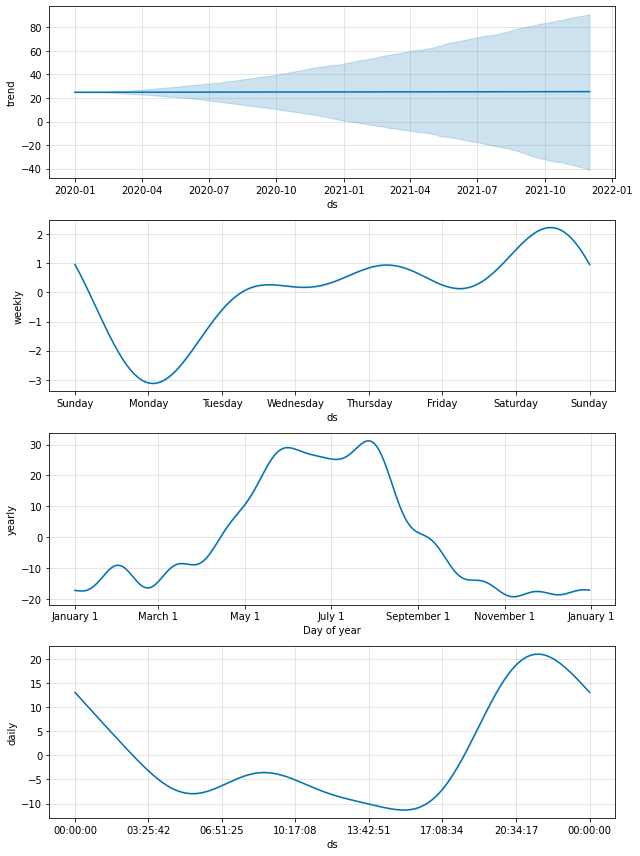

In [15]:
model.plot_components(forecast)

#Análisis

In [16]:
print(f'R2  : {r2_score(df_prophet_test["y"], forecast["yhat"])}')
print(f'MSE : {mean_squared_error(df_prophet_test["y"], forecast["yhat"])}')
print(f'MAE : {mean_absolute_error(df_prophet_test["y"], forecast["yhat"])}')
print(f'MAPE: {mean_absolute_percentage_error(df_prophet_test["y"], forecast["yhat"])}')

R2  : 0.294331215066853
MSE : 844.7041880749754
MAE : 17.3313417061444
MAPE: 1.2286970856214126


#Model Prophet datos por promedio diario

In [25]:
#datos de entrenamiento hasta el 2020-01-01 y el resto de pruebas, se uso esta 
#fecha ya que aproximadamente un 20% de los datos totales, lo que deja un 80% 



#la separacion de los datos se realiza en base a una fecha limite que en este 
#caso es el comiezo de 2020, no con porcentajes, ya que tenemos un mayor control.
train_range_Mean = dfMean[dfMean.fecha < '2020-01-01'].index
test_range_Mean = dfMean[(dfMean.fecha >= '2020-01-01')].index
train_range_Mean

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458],
           dtype='int64', length=2459)

##Grafico con separación de datos por pruebas y entrenamiento.

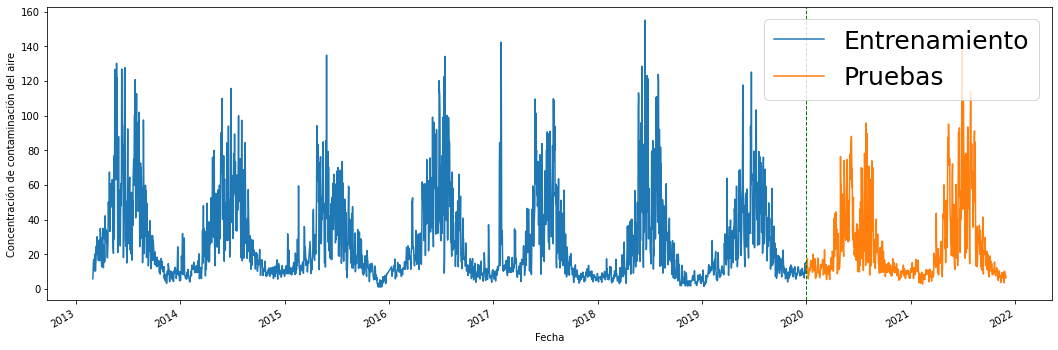

In [18]:
fig, ax = plt.subplots(figsize=(18,6))
dfMean.loc[train_range_Mean].plot(x="fecha", y="valor", ax=ax, label="Entrenamiento")
dfMean.loc[test_range_Mean].plot(x="fecha", y="valor", ax=ax, label="Pruebas")
plt.legend(loc='best')
plt.axvline(pd.to_datetime(str(dfMean.loc[test_range_Mean].fecha.values[0])), c='green', ls='--', lw=1)
plt.legend(prop={'size': 25},)
plt.xlabel('Fecha') 
plt.ylabel('Concentración de contaminación del aire')
plt.show()

#Entrenamiento

In [20]:
df_prophet_train_Mean = dfMean.loc[train_range_Mean][["fecha", "valor"]]
df_prophet_train_Mean.columns = ["ds", "y"]
model_Mean = Prophet()
model_Mean.fit(df_prophet_train_Mean);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#Pruebas

In [21]:

df_prophet_test_Mean = dfMean.loc[test_range_Mean][["fecha", "valor"]]
df_prophet_test_Mean.columns = ["ds", "y"]

forecast_Mean = model_Mean.predict(df_prophet_test_Mean[['ds']])

forecast_ci_Mean = forecast_Mean[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')

yhat_test_Mean = forecast_Mean.yhat.values
y_test = dfMean.loc[test_range_Mean].valor.values

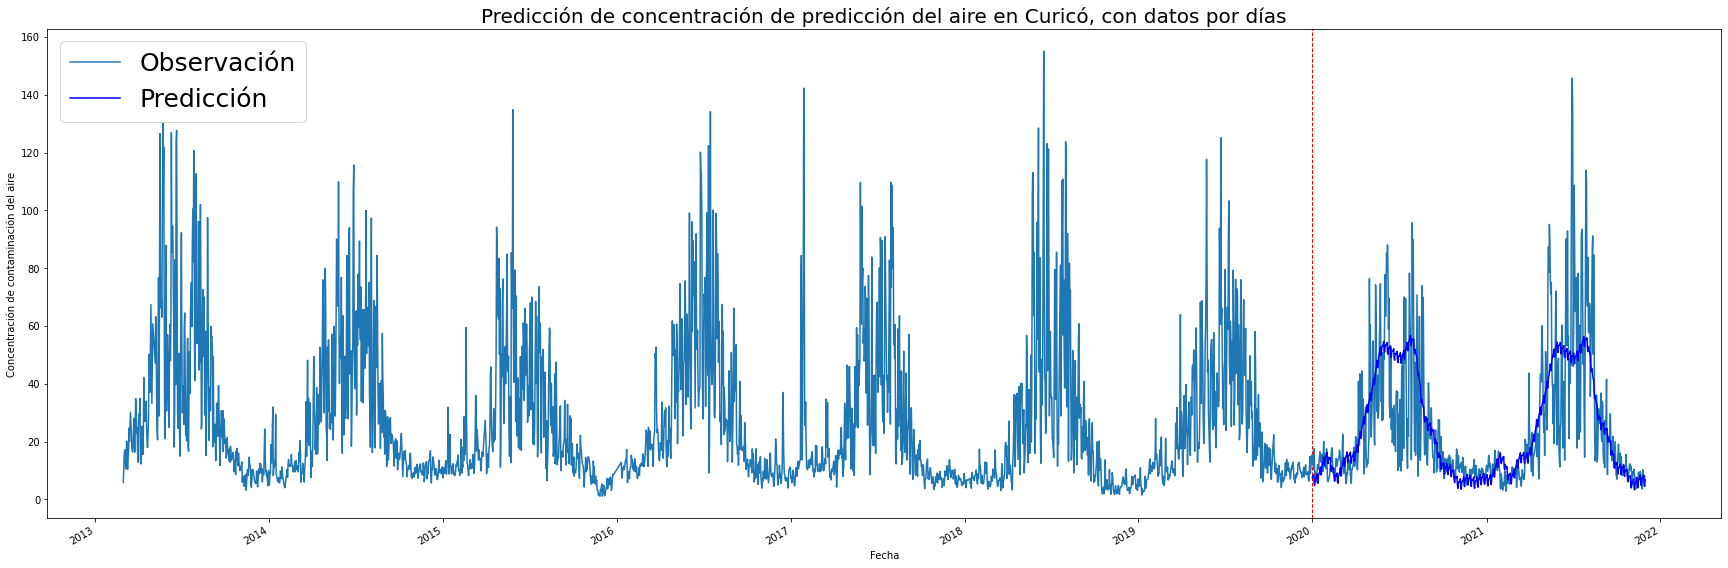

In [22]:
fig, ax = plt.subplots(figsize=(30,10))


plt.axvline(pd.to_datetime(str(dfMean.loc[test_range_Mean].fecha.values[0])), c='red', ls='--', lw=1)
dfMean.plot(x="fecha", y="valor", ax=ax, label="Observación")

ax.plot(pd.to_datetime(dfMean.loc[test_range_Mean].fecha.values), yhat_test_Mean,
        color="blue", label="Predicción")
plt.legend(loc='best')
plt.legend(prop={'size': 25},)
plt.title("Predicción de concentración de predicción del aire en Curicó, con datos por días", fontsize=20)
plt.xlabel('Fecha') 
plt.ylabel('Concentración de contaminación del aire')
plt.show()

Como se puede observar en el grafico anterior, la predicción del modelo se asemeja bastante a los datos registrados en el periodo de pruebas, esto se debe a que los datos no cuenta con una gran dispersión, lo que ayuda al modelo a encontrar patrones más sólidos.

###Gráficos con información de concentración de contaminación en el aire de Curicó 

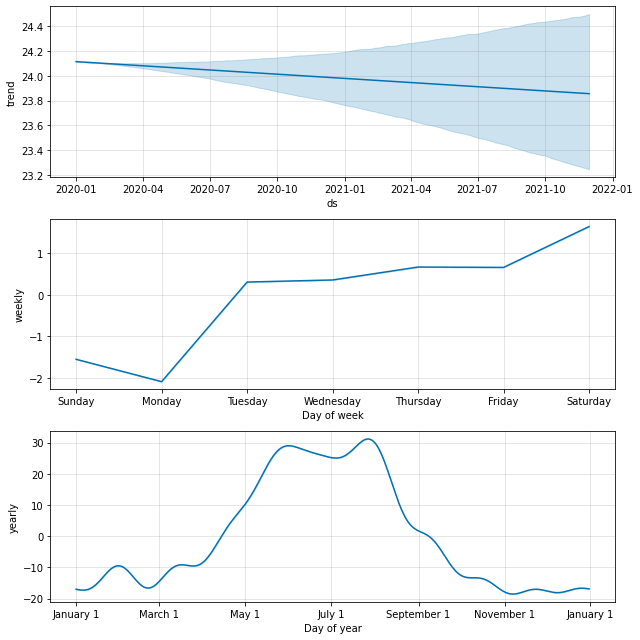

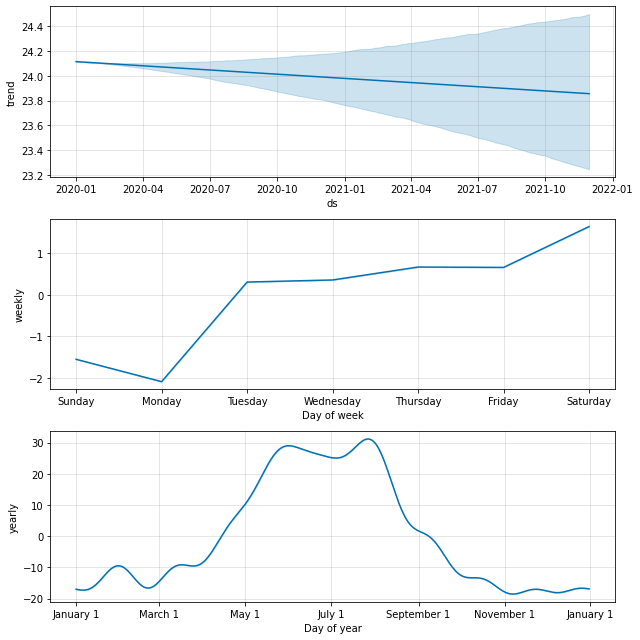

In [23]:
model_Mean.plot_components(forecast_Mean)

#Análisis

In [24]:
print(f'R2  : {r2_score(df_prophet_test_Mean["y"], forecast_Mean["yhat"])}')
print(f'MSE : {mean_squared_error(df_prophet_test_Mean["y"], forecast_Mean["yhat"])}')
print(f'MAE : {mean_absolute_error(df_prophet_test_Mean["y"], forecast_Mean["yhat"])}')
print(f'MAPE: {mean_absolute_percentage_error(df_prophet_test_Mean["y"], forecast_Mean["yhat"])}')

R2  : 0.5272411819314096
MSE : 248.9975302066914
MAE : 9.957866802983531
MAPE: 0.48615776332011346


#Conclución
Como se pudo observar la viabilidad de los modelos va estrechamente relacionado con la dispersión de los datos. En este caso en particular, ya que es una serie de tiempo, habrá que ver si es necesario ajustar los periodos que se usaran (horas, días, semanas, etc.) ya que, si la distribución de los datos no es correcta, podría afectar en la confiabilidad de la predicción.

También hay que tener en cuenta los rangos con los que se trabajan, ya que si estos son muy grandes o muy pequeños, los periodos que se usen también afectaran de buena o mala forma los resultados, ya que podríamos tener muchos o muy pocos datos y esto podría provocar un modelo con un entrenamiento pobre o un modelo sobre entrenado.  
